In [76]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import datetime

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot

## Load data

In [77]:
df = pd.read_csv('avocado.csv')

In [78]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [79]:
df.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

### Create california avocado conventional data

In [80]:
cali_c = df[['Date', 'AveragePrice', 'Total Volume']][(df['type'] == 'conventional') & (df['region'] == 'California')]

In [81]:
cali_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 312 to 8561
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          169 non-null    object 
 1   AveragePrice  169 non-null    float64
 2   Total Volume  169 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.3+ KB


Need to convert Date column data type

In [82]:
cali_c.head(60)

,Date,AveragePrice,Total Volume
312,2015-12-27,0.90,5040365.47
313,2015-12-20,0.94,4695737.21
314,2015-12-13,0.87,5259354.30
315,2015-12-06,0.78,5775536.27
316,2015-11-29,0.91,4575710.62
317,2015-11-22,0.92,4804278.16
318,2015-11-15,0.83,5755190.69
319,2015-11-08,0.98,5148983.51
320,2015-11-01,0.95,5830427.96
321,2015-10-25,1.12,4592461.81


In [83]:
cali_c.tail(20)

,Date,AveragePrice,Total Volume
5979,2017-02-19,0.95,6194368.66
5980,2017-02-12,0.79,6862176.64
5981,2017-02-05,0.67,11213596.29
5982,2017-01-29,0.76,8055482.07
5983,2017-01-22,0.76,8153340.48
5984,2017-01-15,0.93,6656554.36
5985,2017-01-08,1.00,6653048.21
5986,2017-01-01,0.89,7175276.66
8550,2018-03-25,1.04,6687009.44
8551,2018-03-18,1.02,6802084.11


In [84]:
#Set the date column into it right data type
cali_c['Date'] = pd.to_datetime(cali_c['Date'])

In [85]:
cali_c.dtypes

Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
dtype: object

In [86]:
#Sort the Date column ascending
cali_c.sort_values(by=['Date'], inplace=True, ascending=True)

In [87]:
cali_c.set_index('Date', drop = True, inplace = True)

In [88]:
cali_c['Revenue'] = cali_c['AveragePrice'] * cali_c['Total Volume']

In [89]:
cali_c.head()

,AveragePrice,Total Volume,Revenue
Date,,,
2015-01-04,0.93,5777334.90,5.372921e+06
2015-01-11,0.92,6024932.34,5.542938e+06
2015-01-18,1.02,5570915.26,5.682334e+06
2015-01-25,1.06,4929884.26,5.225677e+06
2015-02-01,0.85,9032180.67,7.677354e+06


In [90]:
cali_c.to_csv('cali_c.csv')

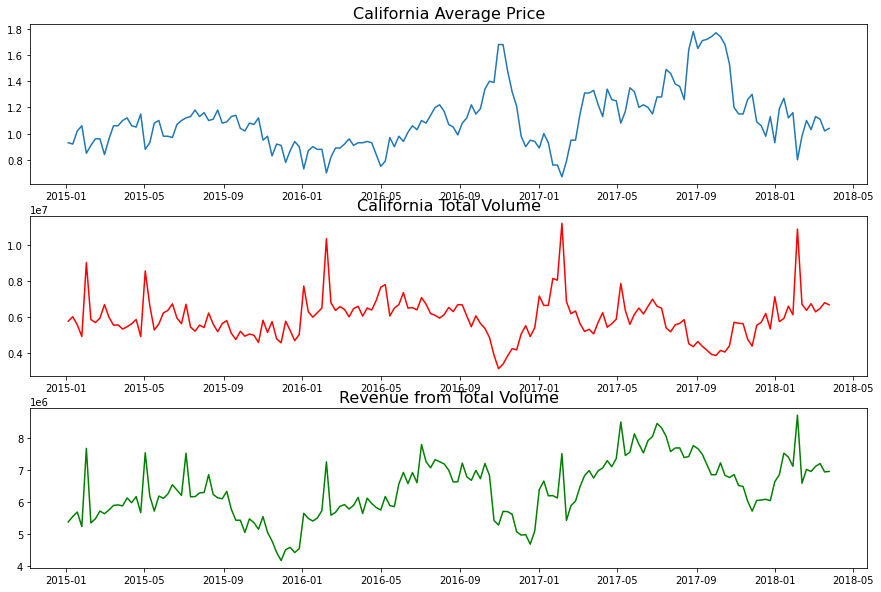

In [92]:
plt.figure(figsize = (15, 10))

plt.subplot(3,1,1)
plt.plot(cali_c['AveragePrice'])
plt.title('California Average Price', size = 16)

plt.subplot(3,1,2)
plt.plot(cali_c['Total Volume'], color = 'r')
plt.title('California Total Volume', size = 16)


plt.subplot(3,1,3)
plt.plot(cali_c['Revenue'], color = 'g')
plt.title('Revenue from Total Volume', size = 16)
plt.savefig('trend2.png')
plt.show()

- There is a seasonal trend from 2015 to 2018:
- The trend of AveragePrice will raise from Sep and droped down in Oct and continued through years. In the opposite, Total Volume trend will raised from the begining of Spring until droped down in May.
- We can see the revenue of conventional avocado increased through years

# Seasonal Decompose

In [17]:
def season_decompose(data, feature):
    result = seasonal_decompose(cali_c[feature], model = 'multiplicative', period = 52)
    plt.rcParams['figure.figsize'] = (14, 9)
    result.plot()
    plt.show()

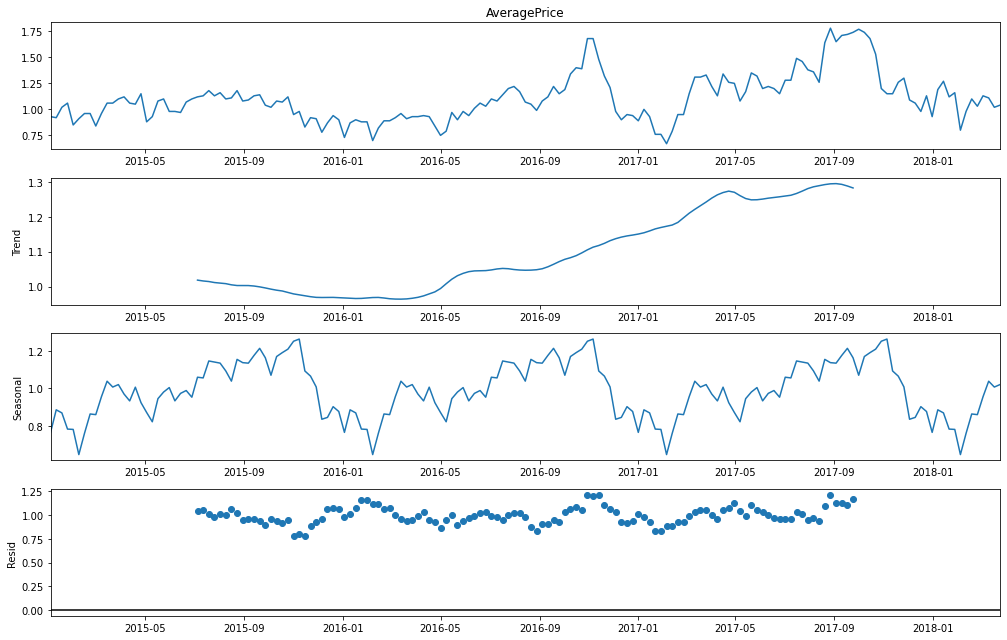

In [18]:
season_decompose(cali_c, 'AveragePrice')

- The Average trend rised up really fast from 2016 to present.
- The spring - summer season are the suitable season for selling conventional avocado when the price droped down, and Volume increased.

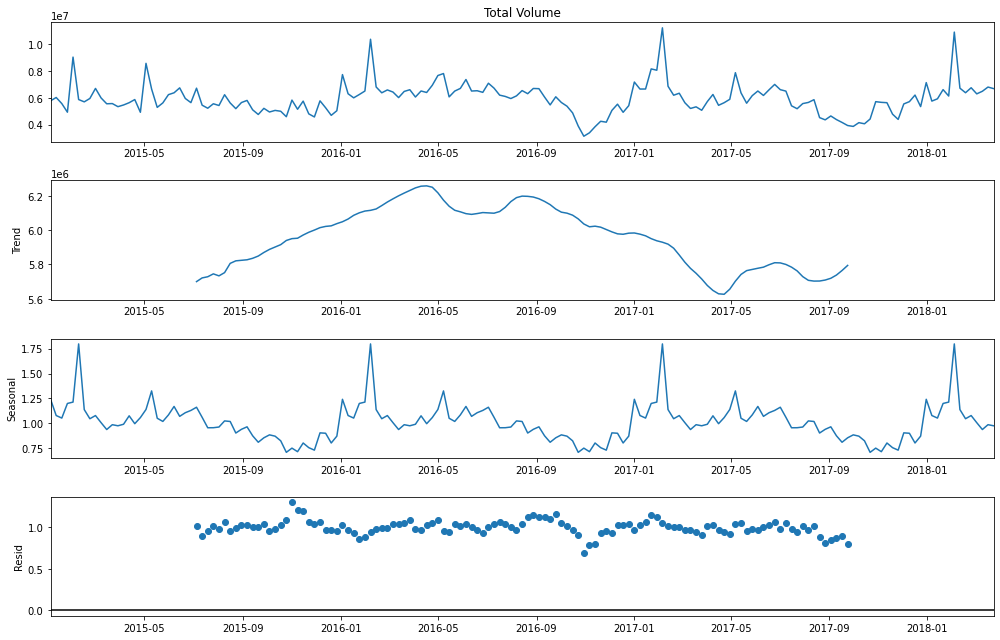

In [19]:
season_decompose(cali_c, 'Total Volume')

- The Total Volume of 2016, 2017 and 2018 are the same.
- There is a seasonal through years.

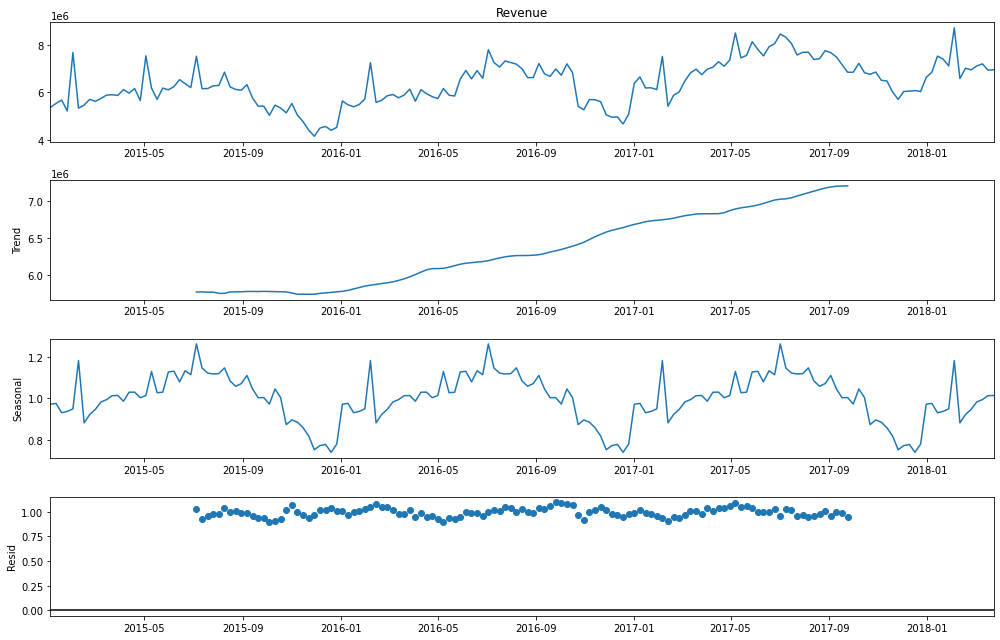

In [20]:
season_decompose(cali_c, 'Revenue')

- As I mentioned, Spring - summer is the suitable moment for making profit, the revenue increased from 2015 to present.

# Select train/test data

In [93]:
#Select X_train/test

train = cali_c['AveragePrice'].loc['2015-01-04': '2017-12-31']
test = cali_c['AveragePrice'].loc['2018-01-07':]

print('Train size:', len(train), '\t\t\t Test size:', len(test))
print('Test size percentage:', round(len(test)/cali_c.shape[0], 2))

Train size: 157 			 Test size: 12
Test size percentage: 0.07


- train data: 157 weeks (3year | 2015 - 12/2017)
- test data: 12 weeks (the first 3 months of 2018)

# Auto Arima

In [21]:
stepwise_model = auto_arima(cali_c['AveragePrice'], start_p=2, start_q=2,
                           m = 52,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print('AIC of the best model: ',stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=52.39 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=-129.561, Time=0.62 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=-148.680, Time=10.37 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=17.71 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=-128.002, Time=0.32 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=31.44 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=39.63 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=7.09 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=-147.380, Time=46.21 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=-150.549, Time=6.05 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=34.43 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=26.25 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=7.63 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=-149.380, Time=28.53 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=-148.68

In [22]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 1, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [19]:
import pmdarima as pm
arima = pm.ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 1, 0, 52),
      suppress_warnings=True, with_intercept=False)
arima.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 1, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [23]:
import pickle
with open('pmdarima2.pkl', 'wb') as pkl:
    pickle.dump(arima, pkl)

In [94]:
arima_forecast = arima.predict(n_periods=len(test))   #n_periods: khoang thoi gian can du bao

In [95]:
arima_forecast = pd.DataFrame(arima_forecast, index = test.index, columns = ['Prediction'])

[]

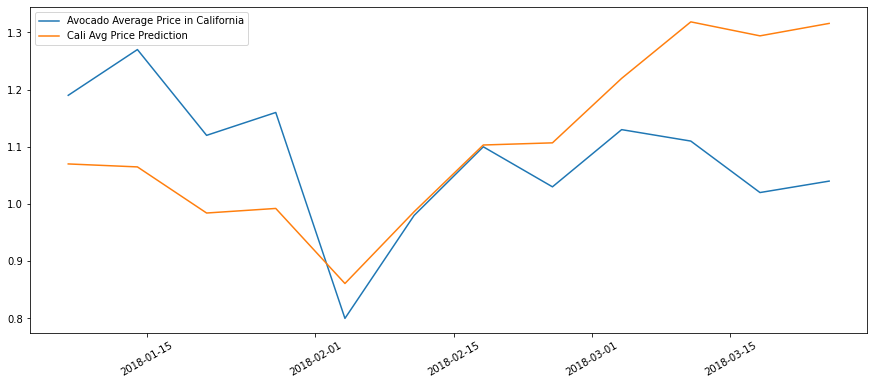

In [96]:
plt.figure(figsize = (15, 6))
plt.subplot(1,1,1)
plt.plot(test, label = 'Avocado Average Price in California')
plt.plot(arima_forecast, label = 'Cali Avg Price Prediction')
plt.xticks(rotation = 30)
plt.legend(loc = 'best')
plt.plot()

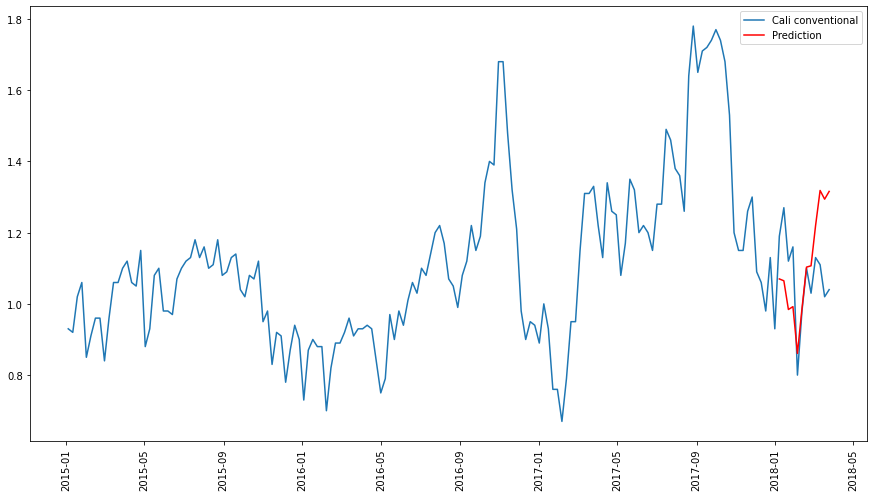

In [97]:
plt.figure(figsize = (15,8))
plt.plot(cali_c['AveragePrice'], label = 'Cali conventional')
plt.plot(arima_forecast, label = 'Prediction', color = 'red')
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()

- The prediction of the first 3 months of 2018 seem difference when there is a huge magin/great fluctuations.
- The mae not big (0.13).

In [98]:
mae = mean_absolute_error(test, arima_forecast[0:len(test)])
mae

0.13532969486227722

In [99]:
test.mean()

1.0791666666666666

### Predict for the next 40 weeks (2018)

In [100]:
arima_forecast_40 = arima.predict(n_periods=len(test) + 40)

[]

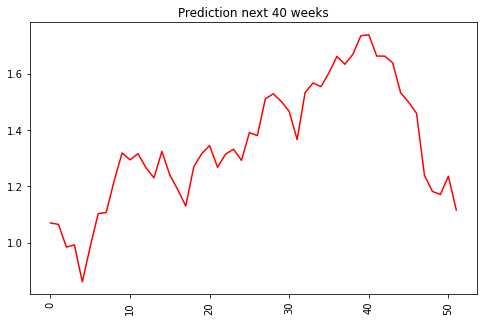

In [101]:
plt.figure(figsize = (8,5))
plt.plot(arima_forecast_40, color = 'red')
plt.xticks(rotation = 'vertical')
plt.title('Prediction next 40 weeks')
plt.plot()

##### Create dataframe for the next 40 week of 2018

In [102]:
#create dât for the next 40 weeks of 2018
weekdays = pd.date_range('2018-04-01', '2018-12-31', freq = 'W').strftime("%Y-%m-%d").tolist()

In [103]:
arima_forecast_40 = pd.DataFrame({'DATE': weekdays,
                                   'cali_c_prediction':arima_forecast_40[len(test):]})

In [104]:
arima_forecast_40['DATE'] = pd.to_datetime(arima_forecast_40['DATE'])

In [105]:
arima_forecast_40.set_index('DATE', drop = True, inplace = True)

In [106]:
arima_forecast_40.head()

,cali_c_prediction
DATE,
2018-04-01,1.265669
2018-04-08,1.230035
2018-04-15,1.324089
2018-04-22,1.239602
2018-04-29,1.187762


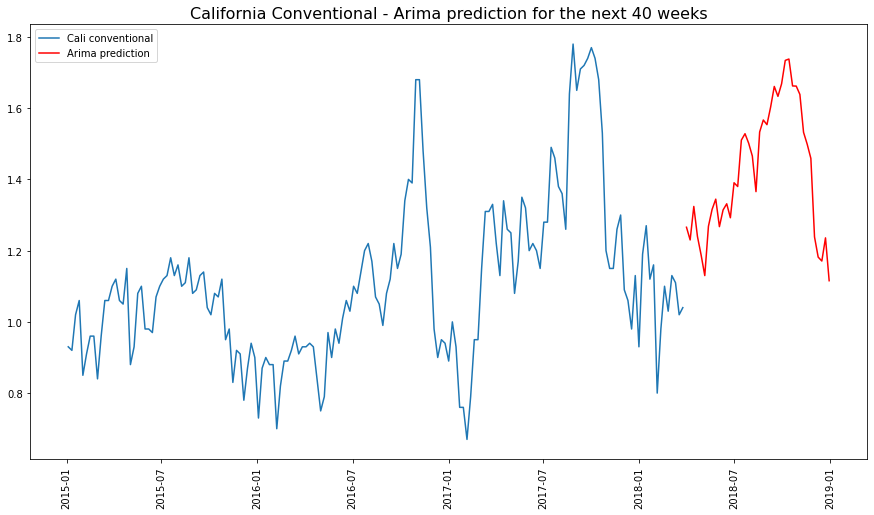

In [114]:
plt.figure(figsize = (15,8))
plt.plot(cali_c['AveragePrice'], label = 'Cali conventional')
plt.plot(arima_forecast_40['cali_c_prediction'], label = 'Arima prediction', color = 'red')
plt.xticks(rotation = 'vertical')
plt.title('California Conventional - Arima prediction for the next 40 weeks', size = 16)
plt.legend()
plt.savefig('arima2.png')
plt.show()

- In the next 40 weeks, there is a good result showed that California will be one of the main market of the organization:
    - The seasonal trend will be continued, but this year (2018) will be chance for us for making profit.
    - The 2018 conventional price will be lower than last year => Revenue will increased.
    - Notice: the down trend of 2019 will be happended really fast, price seem the same with this year prediction (2018) and the slope will like year 2016.

# Holtwinter

In [109]:
holtwinter_model = ExponentialSmoothing(train, seasonal = 'mul',
                             seasonal_periods = 52).fit()
holtwinter_pred = holtwinter_model.predict(start = test.index[0], end = test.index[-1])

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [70]:
with open('holtwinter2.pkl', 'wb') as pkl:
    pickle.dump(holtwinter_model, pkl)

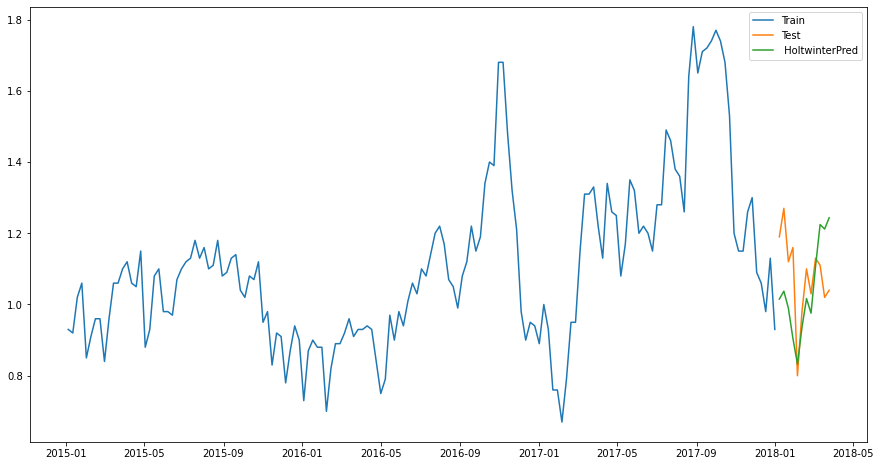

In [110]:
plt.figure(figsize = (15,8))
plt.plot(train.index, train, label = 'Train')
plt.plot(test.index, test, label = 'Test')
plt.plot(holtwinter_pred.index, holtwinter_pred, label = ' HoltwinterPred')
plt.legend(loc = 'best')

In [111]:
mae = mean_absolute_error(test, holtwinter_pred[0:len(test)])
mae

0.12830738101314068

##### Create next 40 weeks dataframe for Holtwinter prediction

In [112]:
e = datetime.datetime(2018,12,31)
holtwinter_forecast_40 = holtwinter_model.predict(start = test.index[-1], end = e)
holtwinter_forecast_40 = holtwinter_forecast_40
holtwinter_forecast_40 = pd.Series(holtwinter_forecast_40)

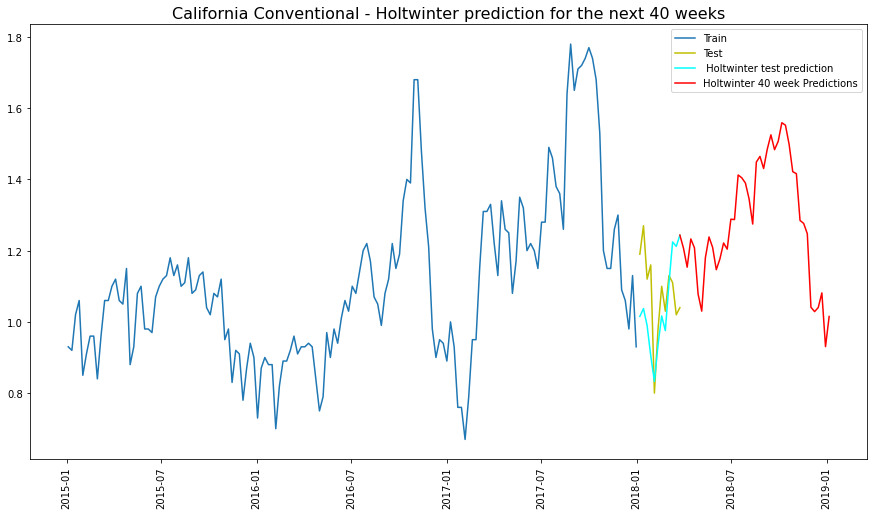

In [115]:
plt.figure(figsize = (15,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test', color = 'y')
plt.plot(holtwinter_pred.index, holtwinter_pred, label = ' Holtwinter test prediction', color = 'cyan')
plt.plot(holtwinter_forecast_40, label = 'Holtwinter 40 week Predictions', color = 'red')
plt.xticks(rotation = 'vertical')
plt.title('California Conventional - Holtwinter prediction for the next 40 weeks', size = 16)
plt.legend()
plt.savefig('holtwinter2.png')
plt.show()

##### Holtwinter Result:
- The price still happened same case with Arima, but the price of prediction seem lower than Arima prediction a lot and it will be continuing its down trend.
- The Holwinter mse is the same as Arima, but give the totaly difference prediction result. I will make a prediction with fbprophet model for advance.

# fbprophet

In [116]:
prophet_df = cali_c['AveragePrice'].copy()
prophet_df = prophet_df.reset_index()

In [117]:
prophet_df.columns = ['ds', 'y']

In [118]:
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      169 non-null    datetime64[ns]
 1   y       169 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


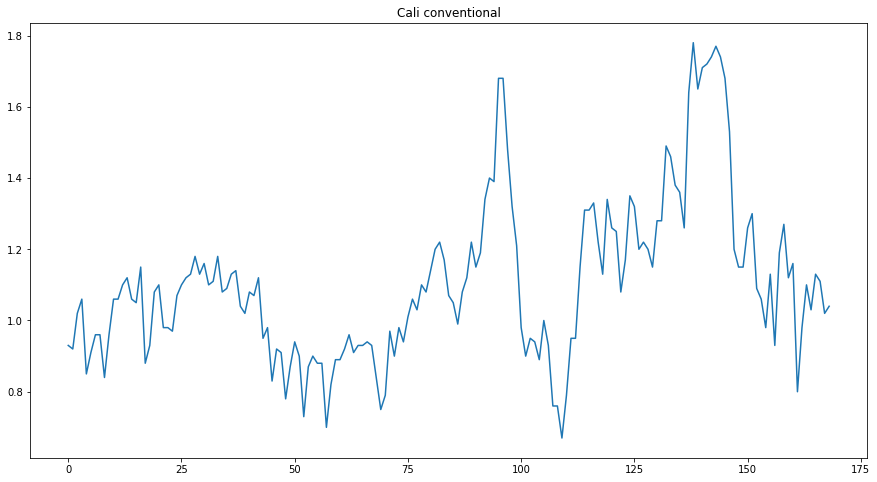

In [119]:
plt.figure(figsize = (15,8))
plt.plot(prophet_df.y)
plt.title('Cali conventional')
plt.show()

- Same plot as above

##### Create train/test data for prophet

In [120]:
#train/test split
train = prophet_df.drop(prophet_df.index[-12:])
test = prophet_df.drop(prophet_df.index[0:-12])

In [121]:
train.tail()

,ds,y
152,2017-12-03,1.09
153,2017-12-10,1.06
154,2017-12-17,0.98
155,2017-12-24,1.13
156,2017-12-31,0.93


In [122]:
test

,ds,y
157,2018-01-07,1.19
158,2018-01-14,1.27
159,2018-01-21,1.12
160,2018-01-28,1.16
161,2018-02-04,0.80
162,2018-02-11,0.98
163,2018-02-18,1.10
164,2018-02-25,1.03
165,2018-03-04,1.13
166,2018-03-11,1.11


In [123]:
prophet_model = Prophet(yearly_seasonality = True, daily_seasonality = False, weekly_seasonality = True)

There is a weekly seasonaality through year so I decided setting the parameter of year and week as True

In [124]:
prophet_model.fit(train)

In [125]:
with open('fbprophet2.pkl', 'wb') as pkl:
    pickle.dump(prophet_model, pkl)

NameError: name 'pickle' is not defined

##### Create data prediction for the whole 2018

In [126]:
#create data for 2018
weeks = pd.date_range('2018-01-07', '2018-12-31',
                      freq = 'W').strftime('%Y-%m-%d').tolist()
prophet_future = pd.DataFrame(weeks)
prophet_future.columns = ['ds']
prophet_future['ds'] = pd.to_datetime(prophet_future['ds'])

In [127]:
prophet_forecast = prophet_model.predict(prophet_future)

In [128]:
prophet_forecast[['ds', 'yhat']]

,ds,yhat
0,2018-01-07,1.210835
1,2018-01-14,1.229651
2,2018-01-21,1.220767
3,2018-01-28,1.188233
4,2018-02-04,1.153022
5,2018-02-11,1.146321
6,2018-02-18,1.188919
7,2018-02-25,1.271580
8,2018-03-04,1.358386
9,2018-03-11,1.415036


In [129]:
print('Mean of original data', prophet_df.y.mean())
print('Mean of test data',test.y.mean())

Mean of original data 1.1054437869822484
Mean of test data 1.0791666666666666


In [130]:
y_test = test['y'].values
y_pred = prophet_forecast['yhat'].values[:12]
mae_p = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f'% mae_p)

rmse_p = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' %rmse_p)

MAE: 0.199
RMSE: 0.244


The mae score of prophet model lower than arima and Holtwinter

In [131]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']),columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']),columns=['Prediction'])

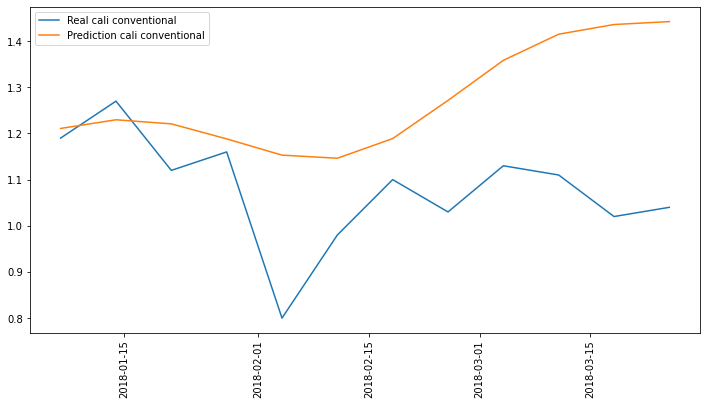

In [132]:
# Visulaize the result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='Real cali conventional')
plt.plot(y_pred_value, label='Prediction cali conventional')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

C:\Users\DELL\AppData\Local\Temp/ipykernel_8348/1313328995.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


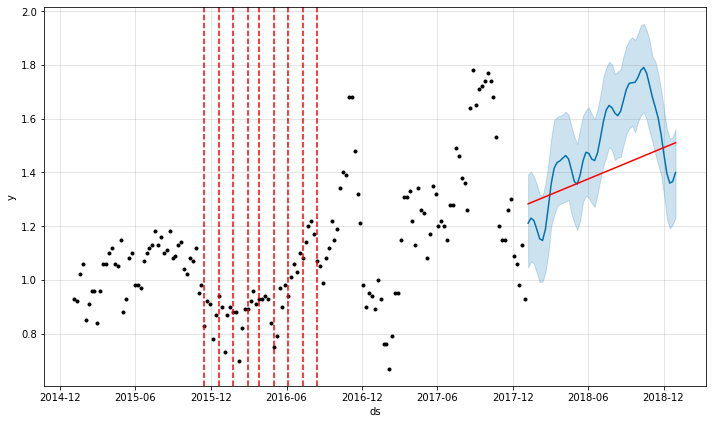

In [133]:
fig = prophet_model.plot(prophet_forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), prophet_model, prophet_forecast)

C:\Users\DELL\AppData\Local\Temp/ipykernel_8348/694214153.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


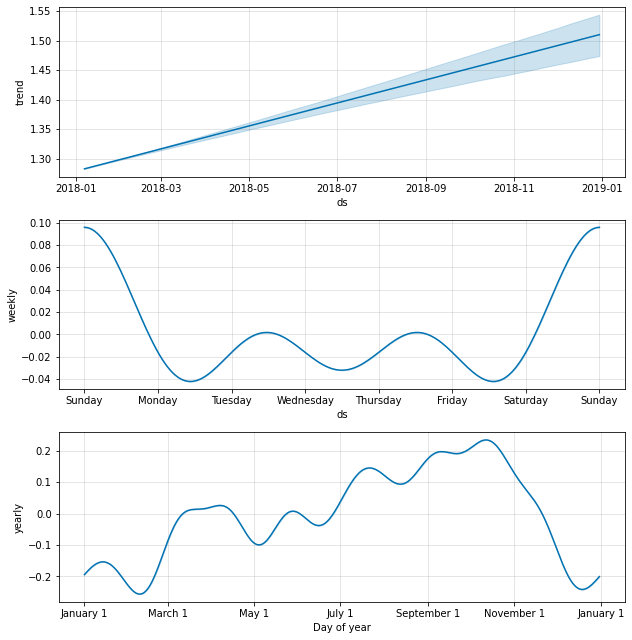

In [134]:
fig1 = prophet_model.plot_components(prophet_forecast)
fig1.show()

- Trend will increased from 2018 to 2019
- Same scenario as Arima model, the trend rised up from summer or fall and droped down really fast at the beginning of winter. This time people does not buy avocados until price low in Jan - May.
- But in this model, we can see activity are really high at the weekend (weekly plot) because customer usually buy stuff for the whole week.

### Long term predict

In [135]:
m = Prophet(yearly_seasonality = True, daily_seasonality = False, weekly_seasonality = True)
m.fit(prophet_df)
prophet_future = m.make_future_dataframe(periods = 54*1, freq = 'W')

In [136]:
prophet_forecast_40 = m.predict(prophet_future)

In [137]:
prophet_forecast_40.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          223 non-null    datetime64[ns]
 1   trend                       223 non-null    float64       
 2   yhat_lower                  223 non-null    float64       
 3   yhat_upper                  223 non-null    float64       
 4   trend_lower                 223 non-null    float64       
 5   trend_upper                 223 non-null    float64       
 6   additive_terms              223 non-null    float64       
 7   additive_terms_lower        223 non-null    float64       
 8   additive_terms_upper        223 non-null    float64       
 9   weekly                      223 non-null    float64       
 10  weekly_lower                223 non-null    float64       
 11  weekly_upper                223 non-null    float64       

In [138]:
prophet_forecast_40[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
211,2019-01-20,1.313950,1.151236,1.482898,1.378362,1.357330,1.397820
212,2019-01-27,1.259301,1.085694,1.430496,1.381314,1.359499,1.401437
213,2019-02-03,1.201701,1.021220,1.367152,1.384266,1.361972,1.405429
214,2019-02-10,1.185270,1.013734,1.364716,1.387218,1.364324,1.409117
215,2019-02-17,1.229371,1.058023,1.409216,1.390171,1.366138,1.412805
216,2019-02-24,1.310374,1.143833,1.478544,1.393123,1.368157,1.416633
217,2019-03-03,1.381387,1.210563,1.559868,1.396075,1.370278,1.420586
218,2019-03-10,1.414323,1.233312,1.579285,1.399027,1.372573,1.424496
219,2019-03-17,1.422753,1.244791,1.594874,1.401979,1.374891,1.428529
220,2019-03-24,1.441369,1.272364,1.628974,1.404931,1.376804,1.432452


C:\Users\DELL\AppData\Local\Temp/ipykernel_8348/3619656754.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


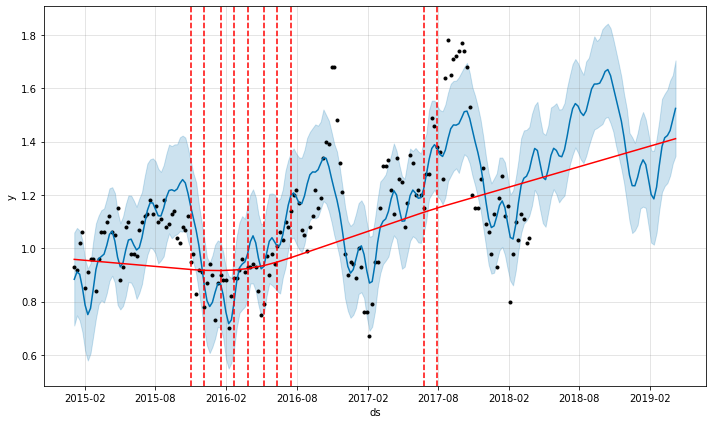

In [139]:
fig = m.plot(prophet_forecast_40)
fig.show()
a = add_changepoints_to_plot(fig.gca(), m, prophet_forecast_40)

- The prophet model prediction give the same result as arima:
    - The trend will be continued and its price will be the highest of all year.

C:\Users\DELL\AppData\Local\Temp/ipykernel_8348/71187928.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


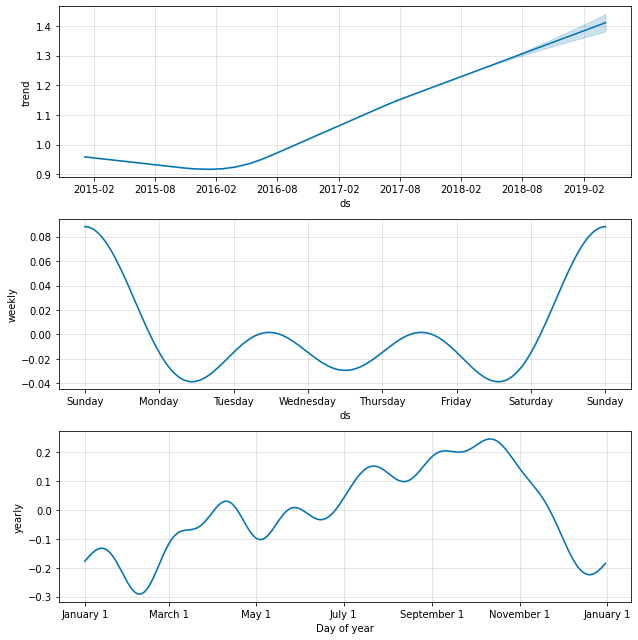

In [140]:
fig1 = m.plot_components(prophet_forecast_40)
fig1.show()

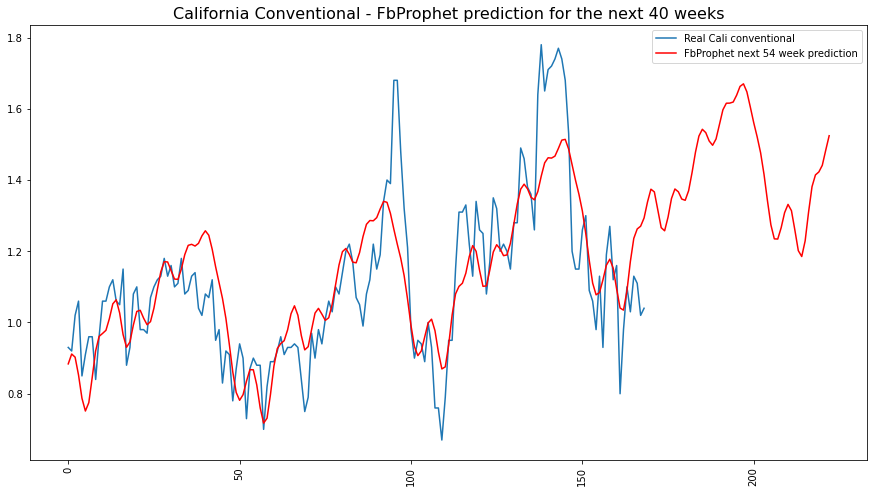

In [143]:
plt.figure(figsize=(15,8))
plt.plot(prophet_df['y'], label='Real Cali conventional')
plt.plot(prophet_forecast_40['yhat'], label='FbProphet next 54 week prediction', 
         color='red')
plt.xticks(rotation='vertical')
plt.title('California Conventional - FbProphet prediction for the next 40 weeks', size = 16)
plt.legend()
plt.savefig('fbprophet2.png')
plt.show()

- Prophet trend seem quite safe, showed that it can not react with fluctuation just like arima and Holtwinter. Besides, the prediction result showed that this and next year price will increased.
- The Cali conventional market will continued as one of the biggest market of us.

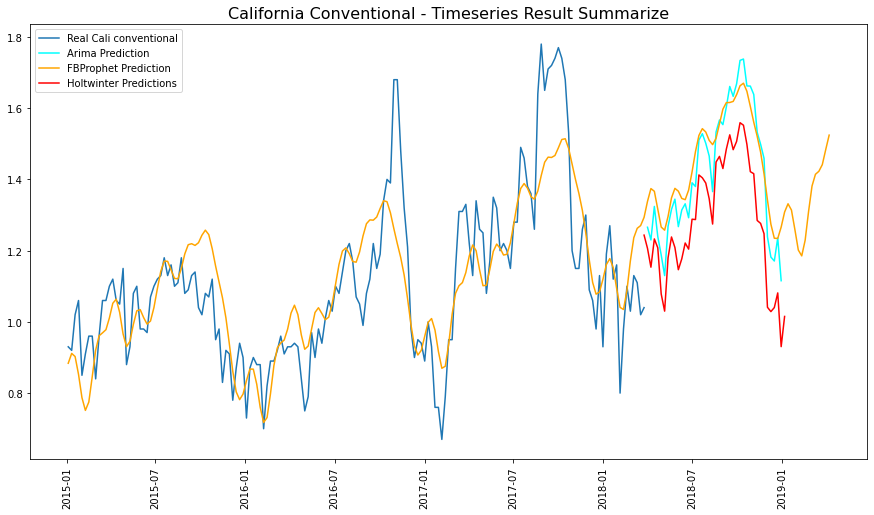

In [144]:
plt.figure(figsize=(15,8))
plt.plot(cali_c['AveragePrice'], label='Real Cali conventional')
plt.plot(arima_forecast_40['cali_c_prediction'], label = 'Arima Prediction', color = 'cyan')
plt.plot(prophet_forecast_40[['ds', 'yhat']].set_index('ds'), label='FBProphet Prediction', 
         color='orange')
plt.plot(holtwinter_forecast_40, label = 'Holtwinter Predictions', color = 'red')
plt.title('California Conventional - Timeseries Result Summarize', size = 16)
plt.xticks(rotation='vertical')
plt.legend()
plt.savefig('result_summarize2.png')
plt.show()

### In conclusion:
- The Arima and Holtwinter will be best fit with the data, in my case prefer Holtwinter for flunctuation tactic and Arima for trend tactics.
    - The Holtwinter seem to be good, but it value prediction is quite low to Arima's functuation and it good for showing a chance in making profit (price drop down in this year) => volume increased..
    - In the other hand, we can use Arima for backup plan if the functuation comed up.
- Those 2 model are good, it showed us the price will continuing growth in 2018 and 2019. In this case, Fbprophet does not convince much.
- So that California willl still our main market in the next year for conventional product.

### Thank you very much for your time